In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from dmrgwaytorho import *
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
from functions import doApplyHam,isingmodel,diagonalize
from functions import isingmodel_rev,isingmodel_rev_frac2,construct_ham,construct_distant_ham_2sites
import itertools as it
import qutip as q

In [2]:
L=2
lambdarange=np.linspace(0.1,2,200)

In [3]:
def func1(phi,l,lamb):
    
    part1=(lamb-np.cos(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
    
    return part1*np.cos(l*phi)/np.pi

def func2(phi,l,lamb):
    
    part2=(np.sin(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
    
    return -part2*np.sin(l*phi)/np.pi

def gfunc(l,lamb):
    
    integ1=integrate.quad(func1,0,np.pi,args=(l,lamb))
    integ2=integrate.quad(func2,0,np.pi,args=(l,lamb))
    
    return integ1[0]-integ2[0]

def assign_g(a,b,g,lamb):
    if a==b:
        return 0
    d=b-a 
    if d%2==1:
        if a%2==1:
            return 1j*g[(d-1)//2,lamb]
        elif a%2==0:
            
            return -1j*g[-((d+1)//2),lamb]
    else:
        return 0
def get_mat(gdic,lam):
    mat = [[None for c in range(1,2*L+1)] for r in range(1,2*L+1)]
    for x in range(1,2*L+1):
        for y in range(1,2*L+1):
            mat[x-1][y-1]=assign_g(x,y,gdic,lam)  
    return np.array(mat)

def g_s(lambdas,L):

    g={}
    for n in range(-L,L): 
        for l in lambdas:
            g[n,l]=gfunc(n,l)
    return g


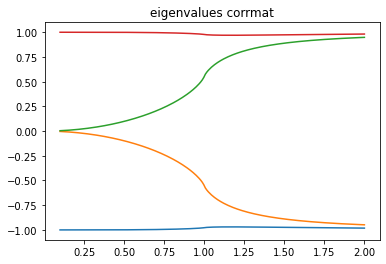

In [4]:
gdic=g_s(lambdarange,L)
autov={}
for i,x in enumerate(lambdarange):
    matr=get_mat(gdic,x)
    autov[i]=eigvalsh(matr)
    
autovals=np.array([autov[i] for i in autov])
plt.plot(lambdarange,autovals)
plt.title("eigenvalues corrmat")
plt.show()

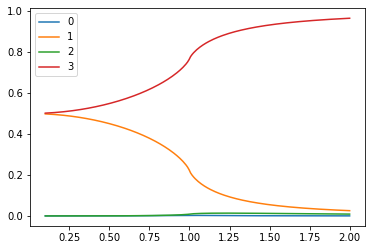

In [5]:
nus=autovals[:,L:]

eigrho={}
for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
    signarr=np.array(sign)
    for i,row in enumerate(nus):
        rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
        eigrho[i,j]=np.prod(rowsign)
for k in range(2**L):
    temp_eigs=[]
    temp_eigs=[eigrho[x,k] for x in range(len(lambdarange))]
    plt.plot(lambdarange,temp_eigs,label=k)
    plt.legend()

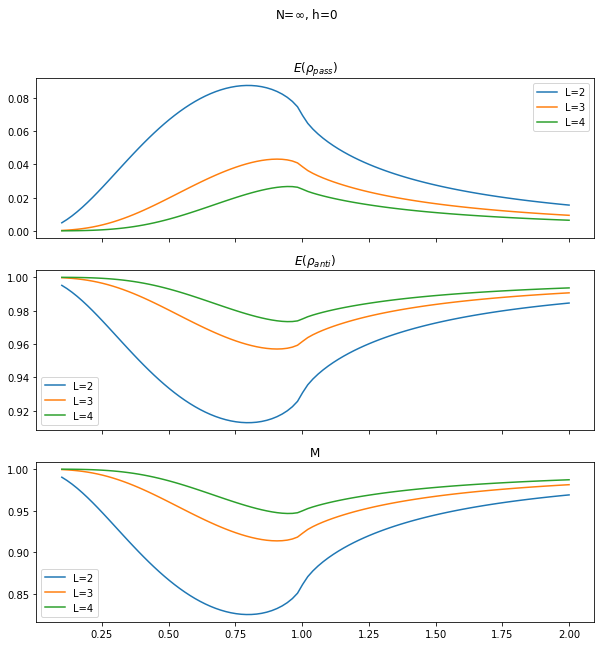

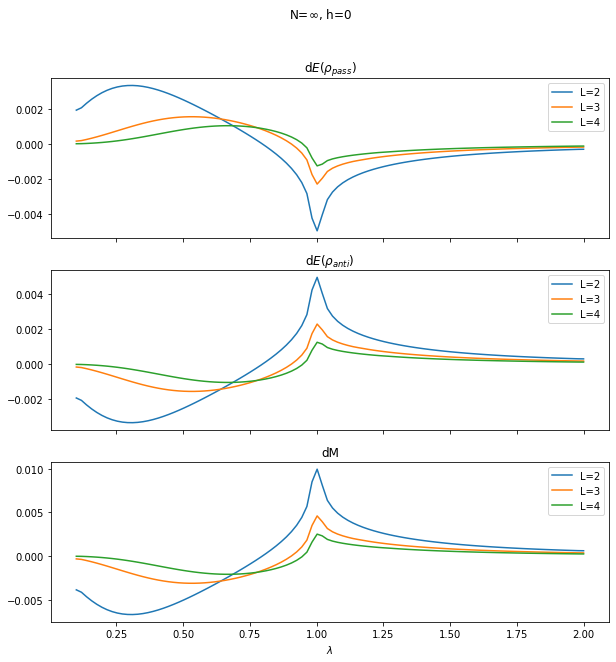

In [6]:

fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])

lambdarange=np.linspace(0.1,2,100)
for L in (2,3,4):
    
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    eigrho={}
    for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
        signarr=np.array(sign)
        for i,row in enumerate(nus):
            rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
            eigrho[i,j]=np.prod(rowsign)
            
            
    energies_pass=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,x] for x in range(2**L)]
        
        eigval=np.sort(eigval)
        
        reduced_H_matr=construct_ham(L,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))

    axs[0].plot(lambdarange,energies_pass,label= "L={}".format(L))
    axs[0].set_title(r"$E(\rho_{pass})$")
    axs[1].plot(lambdarange,energies_antipass,label="L={}".format(L))
    axs[1].set_title(r"$E(\rho_{anti})$")
    axs[2].plot(lambdarange,(energies_antipass-energies_pass),label="L={}".format(L))
    axs[2].set_title("M")
    fig.suptitle(r"N=$\infty$, h=0")
    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig.savefig("ergostheo")
    fig2.suptitle(r"N=$\infty$, h=0")
    
    axs2[0].plot(lambdarange,np.gradient(energies_pass),label= "L={}".format(L))
    axs2[0].set_title(r"d$E(\rho_{pass})$")
    axs2[1].plot(lambdarange,np.gradient(energies_antipass),label="L={}".format(L))
    axs2[1].set_title(r"d$E(\rho_{anti})$")
    axs2[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="L={}".format(L))
    axs2[2].set_title("dM")    
    
    for k in range(3):
        axs2[k].legend()
    fig2.savefig("d_ergostheo")

plt.show()   

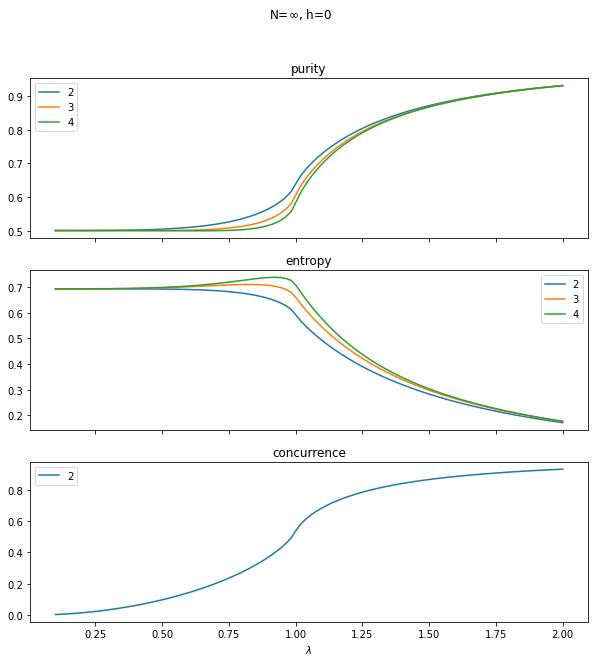

In [7]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in (2,3,4):
       
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    eigrho={}
    for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
        signarr=np.array(sign)
        for i,row in enumerate(nus):
            rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
            eigrho[i,j]=np.prod(rowsign)
            
    purs=[]

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,n] for n in range(2**L)]

        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))

    axs[0].plot(lambdarange,purs,label=L)
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,n] for n in range(2**L)]

        entr=np.sum([ -x*np.log(x) for x in eigval])

        entros.append(entr)

    axs[1].plot(lambdarange,entros,label=L)
    axs[1].legend()
    axs[1].set_title("entropy")
    if L==2:
        concs=[]

        for j,l in enumerate(lambdarange):    

            eigval=[eigrho[j,n] for n in range(2**L)]
            
            eigval=np.sort(eigval)
            
            conc=max(0,eigval[3]-eigval[2]-eigval[1]-eigval[0])

            concs.append(conc)

        axs[2].plot(lambdarange,concs,label=2)
        plt.xlabel(r"$\lambda$")
        axs[2].set_title("concurrence")

        axs[2].legend()
        fig.suptitle( r'N=$\infty$, h=0')   
plt.savefig("theo_quantities")
plt.show()

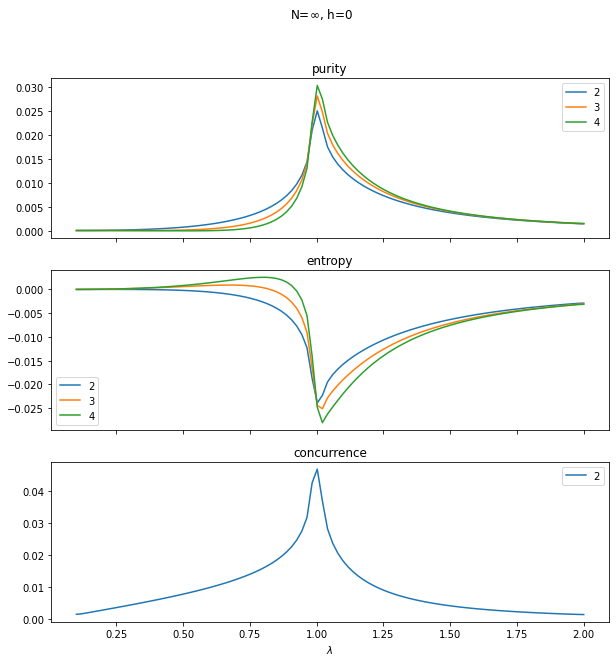

In [13]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in (2,3,4):
       
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    eigrho={}
    for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
        signarr=np.array(sign)
        for i,row in enumerate(nus):
            rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
            eigrho[i,j]=np.prod(rowsign)
            
    purs=[]

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,n] for n in range(2**L)]

        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))
    purs=np.array(purs)
    axs[0].plot(lambdarange,np.gradient(purs),label=L)
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,n] for n in range(2**L)]

        entr=np.sum([ -x*np.log(x) for x in eigval])

        entros.append(entr)
    entros=np.array(entros)
    axs[1].plot(lambdarange,np.gradient(entros),label=L)
    axs[1].legend()
    axs[1].set_title("entropy")
    if L==2:
        concs=[]

        for j,l in enumerate(lambdarange):    

            eigval=[eigrho[j,n] for n in range(2**L)]
            
            eigval=np.sort(eigval)
            
            conc=max(0,eigval[3]-eigval[2]-eigval[1]-eigval[0])

            concs.append(conc)
        concs= np.array(concs)
        axs[2].plot(lambdarange,np.gradient(concs),label=2)
        plt.xlabel(r"$\lambda$")
        axs[2].set_title("concurrence")

        axs[2].legend()
        fig.suptitle( r'N=$\infty$, h=0')   
plt.show()

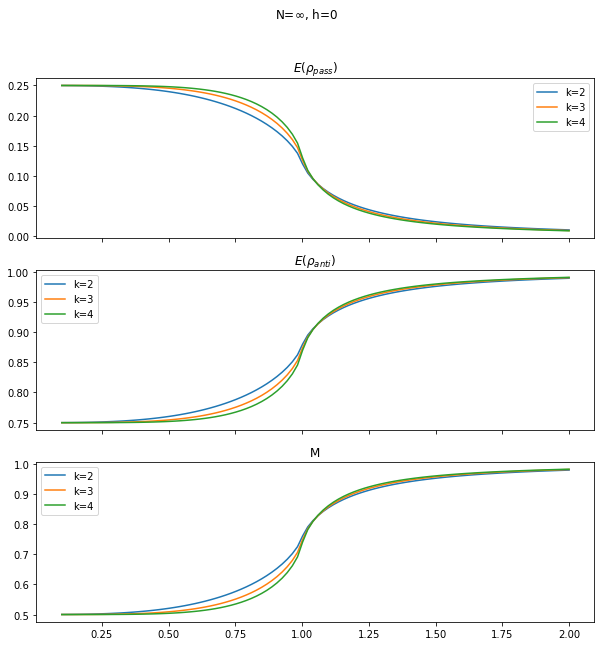

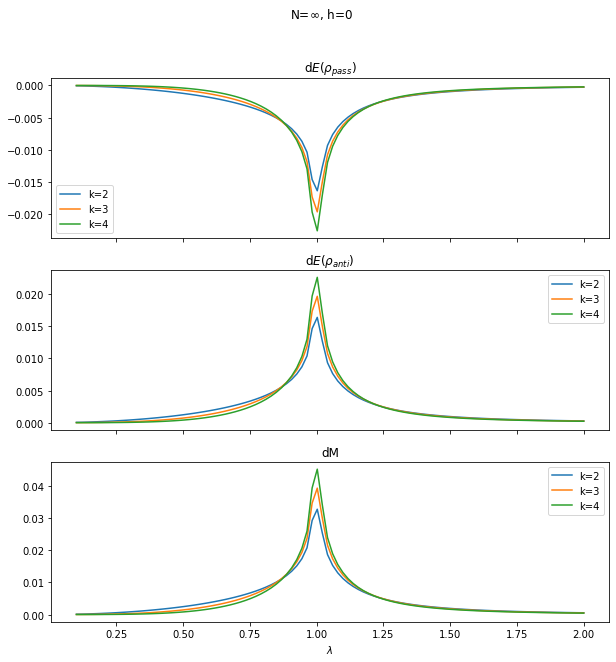

In [8]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])

lambdarange=np.linspace(0.1,2,100)
for L in (3,4,5):
    
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]
    firstnu=nus[:,0]
    lastnu=nus[:,-1]

    energies_pass=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        eigval=[(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])]
       
        eigval=np.sort(eigval)/4
        
        reduced_H_matr=construct_distant_ham_2sites(2,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))

    axs[0].plot(lambdarange,energies_pass,label= "k={}".format(L-1))
    axs[0].set_title(r"$E(\rho_{pass})$")
    axs[1].plot(lambdarange,energies_antipass,label="k={}".format(L-1))
    axs[1].set_title(r"$E(\rho_{anti})$")
    axs[2].plot(lambdarange,(energies_antipass-energies_pass),label="k={}".format(L-1))
    axs[2].set_title("M")
    fig.suptitle(r"N=$\infty$, h=0")
    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig2.suptitle(r"N=$\infty$, h=0")
    
    axs2[0].plot(lambdarange,np.gradient(energies_pass),label= "k={}".format(L-1))
    axs2[0].set_title(r"d$E(\rho_{pass})$")
    axs2[1].plot(lambdarange,np.gradient(energies_antipass),label="k={}".format(L-1))
    axs2[1].set_title(r"d$E(\rho_{anti})$")
    axs2[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="k={}".format(L-1))
    axs2[2].set_title("dM")    
    
    for k in range(3):
        axs2[k].legend()

plt.show()   

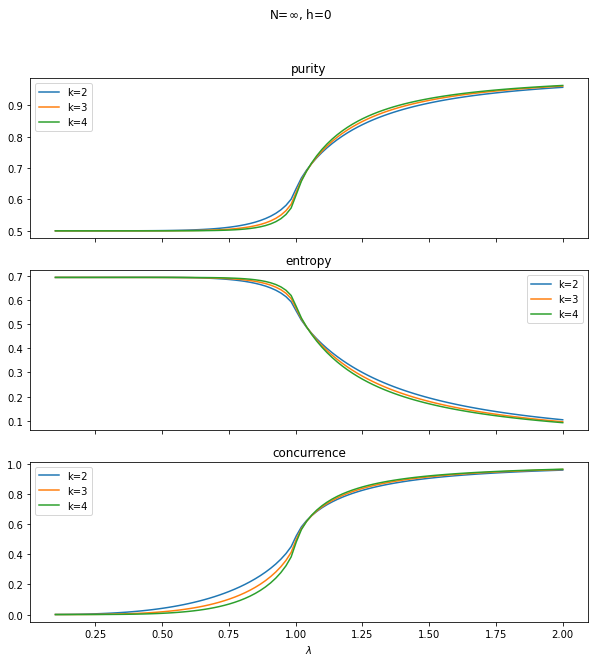

In [9]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in range(3,6):
       
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    firstnu=nus[:,0]
    lastnu=nus[:,-1]
            
    purs=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])

        eigval=eigval/4
        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))

    axs[0].plot(lambdarange,purs,label="k={}".format(L-1))
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])
        
        eigval=eigval/4

        entr=np.sum([ -x*np.log(x) for x in eigval])

        entros.append(entr)

    axs[1].plot(lambdarange,entros,label="k={}".format(L-1))
    axs[1].legend()
    axs[1].set_title("entropy")
    concs=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])

        eigval=eigval/4

        conc=max(0,eigval[3]-eigval[2]-eigval[1]-eigval[0])

        concs.append(conc)

    axs[2].plot(lambdarange,concs,label="k={}".format(L-1))
    plt.xlabel(r"$\lambda$")
    axs[2].set_title("concurrence")

    axs[2].legend()
    fig.suptitle( r'N=$\infty$, h=0')   
plt.show()

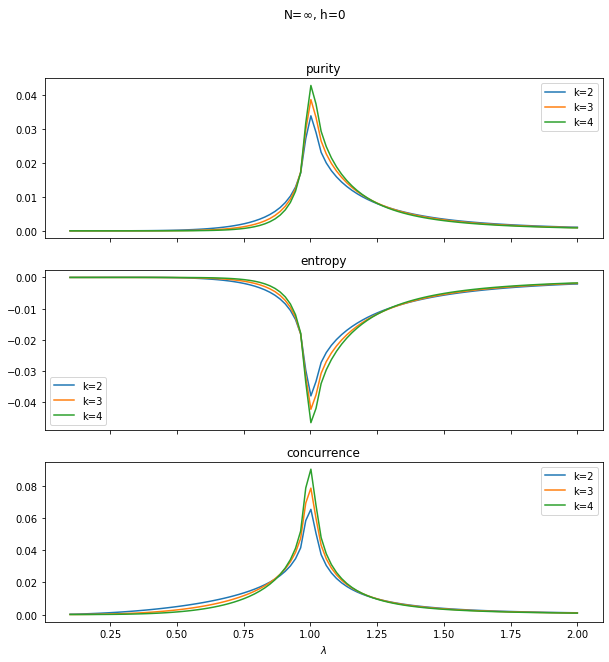

In [11]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in range(3,6):
       
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    firstnu=nus[:,0]
    lastnu=nus[:,-1]
            
    purs=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])

        eigval=eigval/4
        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))
    
    purs=np.array(purs)

    axs[0].plot(lambdarange,np.gradient(purs),label="k={}".format(L-1))
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])
        
        eigval=eigval/4

        entr=np.sum([ -x*np.log(x) for x in eigval])

        entros.append(entr)
    
    entros=np.array(entros)

    axs[1].plot(lambdarange,np.gradient(entros),label="k={}".format(L-1))
    axs[1].legend()
    axs[1].set_title("entropy")
    concs=[]

    for j,l in enumerate(lambdarange):    

        eigval=np.sort([(1+firstnu[j])*(1+lastnu[j]),(1-firstnu[j])*(1+lastnu[j]),(1+firstnu[j])*(1-lastnu[j]),(1-firstnu[j])*(1-lastnu[j])])

        eigval=eigval/4

        conc=max(0,eigval[3]-eigval[2]-eigval[1]-eigval[0])

        concs.append(conc)
    
    concs=np.array(concs)

    axs[2].plot(lambdarange,np.gradient(concs),label="k={}".format(L-1))
    plt.xlabel(r"$\lambda$")
    axs[2].set_title("concurrence")

    axs[2].legend()
    fig.suptitle( r'N=$\infty$, h=0')   
plt.show()

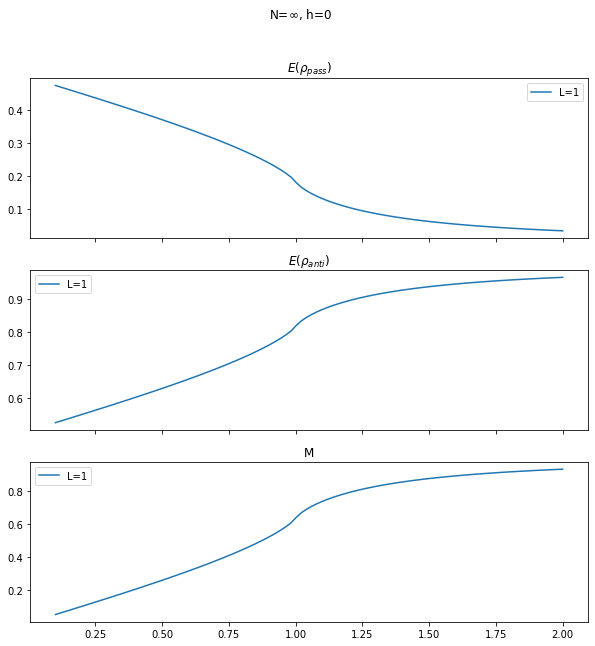

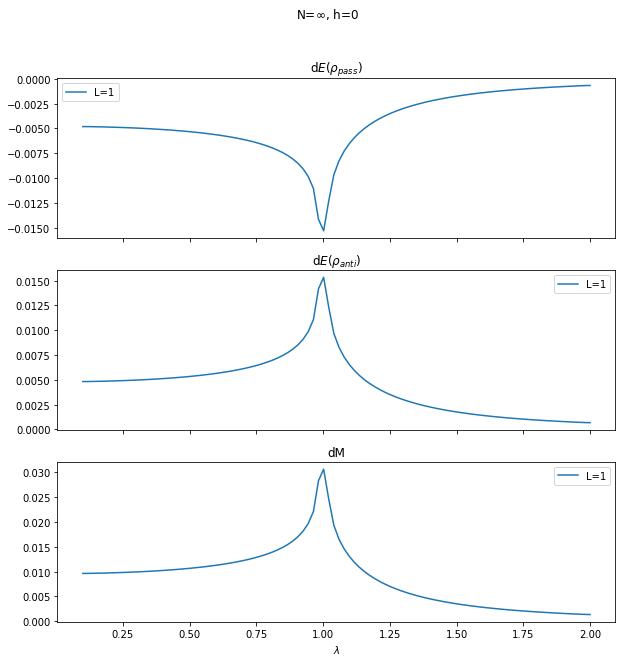

In [12]:

fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])

lambdarange=np.linspace(0.1,2,100)
for L in (1,):
    
    gdic=g_s(lambdarange,L)
    autov={}
    for i,x in enumerate(lambdarange):
        matr=get_mat(gdic,x)
        autov[i]=eigvalsh(matr)
    
    autovals=np.array([autov[i] for i in autov])
    nus=autovals[:,L:]

    eigrho={}
    for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
        signarr=np.array(sign)
        for i,row in enumerate(nus):
            rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
            eigrho[i,j]=np.prod(rowsign)
            
            
    energies_pass=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        eigval=[eigrho[j,x] for x in range(2**L)]
        
        eigval=np.sort(eigval)
        
        reduced_H_matr=construct_ham(L,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))

    axs[0].plot(lambdarange,energies_pass,label= "L={}".format(L))
    axs[0].set_title(r"$E(\rho_{pass})$")
    axs[1].plot(lambdarange,energies_antipass,label="L={}".format(L))
    axs[1].set_title(r"$E(\rho_{anti})$")
    axs[2].plot(lambdarange,(energies_antipass-energies_pass),label="L={}".format(L))
    axs[2].set_title("M")
    fig.suptitle(r"N=$\infty$, h=0")
    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig2.suptitle(r"N=$\infty$, h=0")
    
    axs2[0].plot(lambdarange,np.gradient(energies_pass),label= "L={}".format(L))
    axs2[0].set_title(r"d$E(\rho_{pass})$")
    axs2[1].plot(lambdarange,np.gradient(energies_antipass),label="L={}".format(L))
    axs2[1].set_title(r"d$E(\rho_{anti})$")
    axs2[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="L={}".format(L))
    axs2[2].set_title("dM")    
    
    for k in range(3):
        axs2[k].legend()

plt.show()   